In [2]:
%matplotlib inline
%load_ext autoreload
%load_ext nengo.ipynb
%autoreload 1

<IPython.core.display.Javascript object>

In [3]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import nengo_spa as spa
import seaborn as sns

In [4]:
%aimport imem
from imem.analysis.context import ContextTestEnv, plot_ctx_net_analysis
from imem.legacy.context import AlternatingMemoryBuffers, BoundedIntegrator, Context4, Context5, ThreeMemory

from imem.utils.plotting import save_tight_fig

In [5]:
sns.set('paper', 'ticks')
figsize = (6.3, 6.3 / 2.)

def eval_net(model, env):
    with nengo.Simulator(model) as sim:
        sim.run(env.n)
    
    fig = plt.figure(figsize=figsize)
    plot_ctx_net_analysis(
        sim.trange(), sim.data[model.p_recalled_ctx], sim.data[model.p_ctx],
        env, fig=fig)
    return fig

def figpath(name):
    return '../../figures/context-analysis/' + name

# Bounded integrator

In [5]:
def BoundedIntegratorTest(env):
    with nengo.Network(seed=2) as model:
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = BoundedIntegrator(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.input)
        nengo.Connection(context_net.current.output, initialization_node)

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
    return model

In [6]:
env = ContextTestEnv(1)

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:235: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


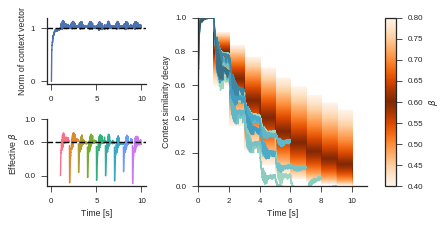

In [6]:
fig = eval_net(BoundedIntegratorTest(env), env)

In [7]:
save_tight_fig(fig, figpath('bounded-integrator-orthogonal.pdf'))

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:235: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


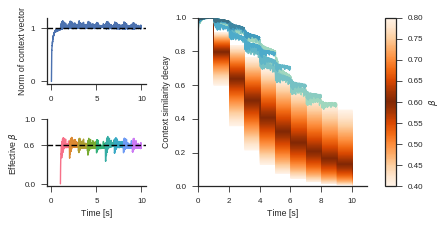

In [8]:
env = ContextTestEnv(1, beta_stim=0.6)
fig = eval_net(BoundedIntegratorTest(env), env)

In [9]:
save_tight_fig(fig, figpath('bounded-integrator.pdf'))

# Alternating memory buffers

In [5]:
def AlternatingMemoryBuffersTest(env):
    with nengo.Network(seed=2) as model:
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = AlternatingMemoryBuffers(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        init_phase = nengo.Node(lambda t: t < env.init_phase)
        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.diff.input)
        nengo.Connection(init_phase, context_net.update_done.neurons,
                         transform=-2. * np.ones((context_net.update_done.n_neurons, 1)))
        nengo.Connection(init_phase, context_net.invert.neurons,
                         transform=-2. * np.ones((context_net.invert.n_neurons, 1)))

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
        
        model.p1 = nengo.Probe(context_net.current.store, synapse=0.01)
        model.p2 = nengo.Probe(context_net.old.store, synapse=0.01)
        model.pd = nengo.Probe(context_net.dot.output, synapse=0.01)
        
    return model

In [6]:
env = ContextTestEnv(1)
m = AlternatingMemoryBuffersTest(env)
with nengo.Simulator(m) as sim:
    sim.run(10.)

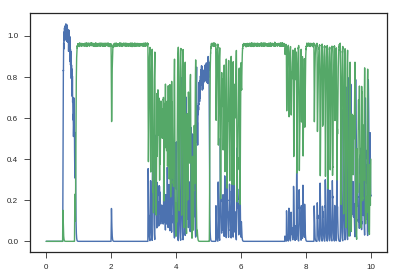

In [7]:
plt.plot(sim.trange(), sim.data[m.p1])
plt.plot(sim.trange(), sim.data[m.p2])

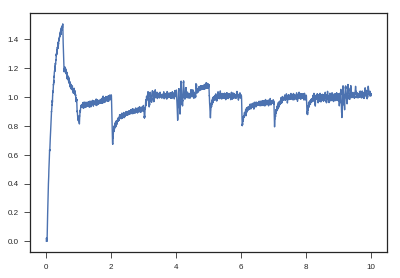

In [8]:
plt.plot(sim.trange(), sim.data[m.pd])

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:235: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


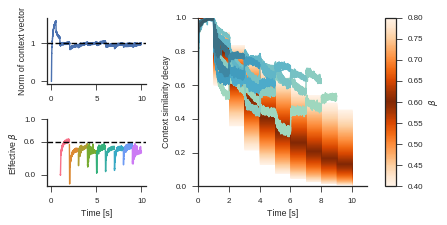

In [9]:
env = ContextTestEnv(1)
fig = eval_net(AlternatingMemoryBuffersTest(env), env)

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:235: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


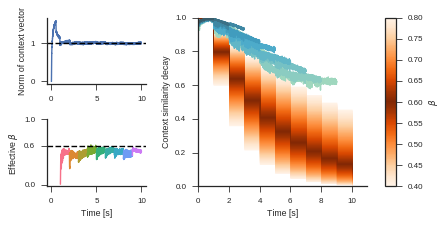

In [10]:
env = ContextTestEnv(1, beta_stim=0.6)
fig = eval_net(AlternatingMemoryBuffersTest(env), env)

In [14]:
save_tight_fig(fig, figpath('alternating-memory-buffers.pdf'))

# Three memory buffer context update

In [ ]:
with nengo.Network(seed=2) as model:
    recalled_ctx = nengo.Node(env.recalled_ctx_fn)
    context_net = ThreeMemory(env.d, env.beta)# + 0.1)  # FIXME correction
    nengo.Connection(recalled_ctx, context_net.input)
    
    initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
    nengo.Connection(initialization_node, context_net.current.diff.input)
    nengo.Connection(initialization_node, context_net.buf.diff.input)
    nengo.Connection(initialization_node, context_net.old.diff.input)
    init_fn = lambda t, x: -x if t < .5 else 0.
    n1 = nengo.Node(init_fn, size_in=1)
    n2 = nengo.Node(init_fn, size_in=1)
    n3 = nengo.Node(init_fn, size_in=1)
    nengo.Connection(n1, context_net.current.store)
    nengo.Connection(context_net.current.store, n1)
    nengo.Connection(n2, context_net.buf.store)
    nengo.Connection(context_net.buf.store, n2)
    nengo.Connection(n3, context_net.old.store)
    nengo.Connection(context_net.old.store, n3)
    
    p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
    p_ctx = nengo.Probe(context_net.output, synapse=0.01)
    
    pd = nengo.utils.probe.probe_all(model, True, {nengo.Node: ['output']}, synapse=0.01)
    pth = nengo.Probe(context_net.update_done_th, synapse=0.01)

In [10]:
with nengo.Simulator(model) as sim:
    sim.run(10.)

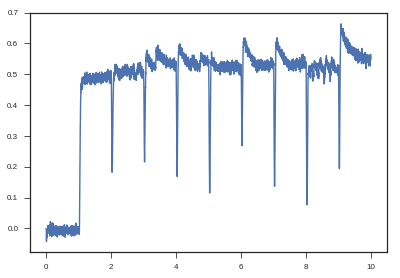

In [11]:
plt.plot(sim.trange(), sim.data[pd[context_net.dot.output]['output']])

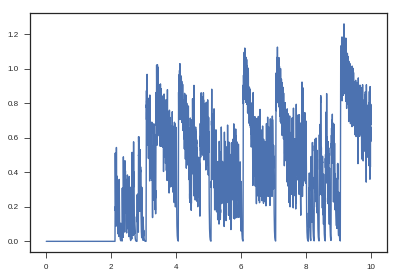

In [12]:
plt.plot(sim.trange(), sim.data[pth])

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:231: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


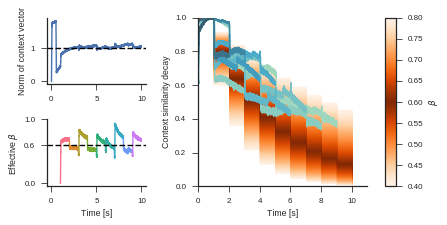

In [19]:
fig = eval_net(model, p_recalled_ctx, p_ctx)

In [8]:
save_tight_fig(fig, figpath('three-memory-buffers.pdf'))

In [9]:
with nengo.Simulator(model) as sim:
    sim.run(10)

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


In [10]:
from imp import reload

In [11]:
import imem.analysis.context
reload(imem.analysis.context)

<module 'imem.analysis.context' from '/home/jgosmann/Documents/projects/imem/imem/analysis/context.py'>

In [12]:
from imem.analysis.context import context_vectors, band_average

In [13]:
actual_ctx = np.mean([sim.data[p_ctx][(1000 * i + 500):(1000 * i + 800)] for i in range(env.n)], axis=1)
actual_ctx /= np.linalg.norm(actual_ctx, axis=1)[:, None]
ideal_ctx = np.asarray([v for i, v in zip(range(env.n), context_vectors(env.vocab, env.beta))])

In [14]:
actual_ctx_similarities = band_average(np.dot(actual_ctx, actual_ctx.T))
ideal_ctx_similarities = band_average(np.dot(ideal_ctx, ideal_ctx.T))

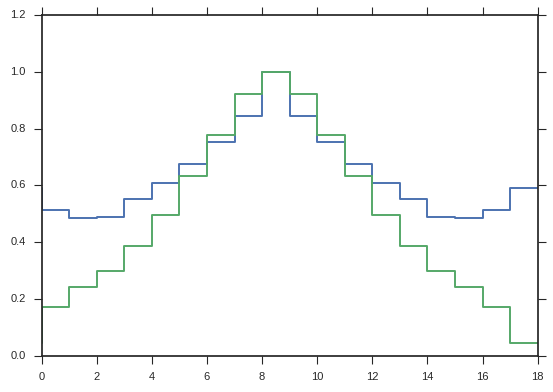

In [15]:
plt.step(np.arange(len(actual_ctx_similarities)), actual_ctx_similarities)
plt.step(np.arange(len(ideal_ctx_similarities)), ideal_ctx_similarities)

# Externally controlled three memory buffer context update

In [11]:
def update_context(t):
    if t < env.init_phase or (t > 1. and .3 < (t % 1.) < .7):
        return 1.
    else:
        return 0.

with nengo.Network(seed=2) as model:
    recalled_ctx = nengo.Node(env.recalled_ctx_fn)
    context_net = Context4(env.d, env.beta)
    nengo.Connection(recalled_ctx, context_net.input)
    
    nengo.Connection(nengo.Node(update_context), context_net.input_update_context)
    
    initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
    nengo.Connection(initialization_node, context_net.current.diff.input)
    nengo.Connection(nengo.Node(lambda t: 4 if t < env.init_phase else 0.), context_net.old.store)
    nengo.Connection(nengo.Node(lambda t: -1 if t < env.init_phase - 0.1 else 0.), context_net.buf.store)
    
    p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
    p_ctx = nengo.Probe(context_net.output, synapse=0.01)

In [12]:
with nengo.Simulator(model) as sim:
    sim.run(10.)

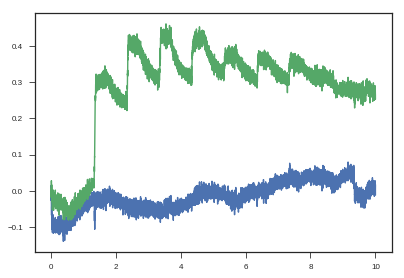

In [13]:
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[0]))
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[1]))

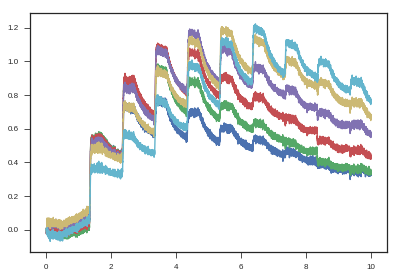

In [14]:
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[2]))
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[3]))
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[4]))
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[5]))
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[6]))
plt.plot(sim.trange(), np.dot(sim.data[p_ctx], cv[7]))

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:231: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


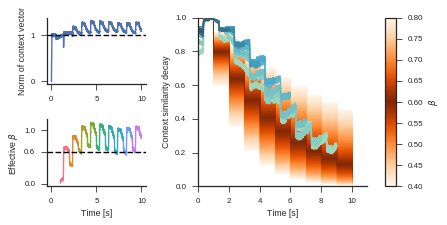

In [15]:
fig = eval_net(model, p_recalled_ctx, p_ctx)

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:231: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


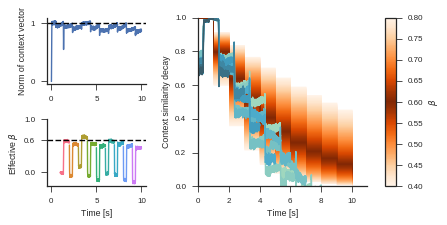

In [7]:
fig = eval_net(model, p_recalled_ctx, p_ctx)

In [29]:
save_tight_fig(fig, figpath('final-context.pdf'))

In [63]:
with nengo.Simulator(model) as sim:
    sim.run(10)

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


In [64]:
actual_ctx = np.mean([sim.data[p_ctx][(1000 * i + 500):(1000 * i + 800)] for i in range(env.n)], axis=1)
actual_ctx /= np.linalg.norm(actual_ctx, axis=1)[:, None]
ideal_ctx = np.asarray([v for i, v in zip(range(env.n), context_vectors(env.vocab, env.beta))])

In [65]:
actual_ctx_similarities = band_average(np.dot(actual_ctx, actual_ctx.T))
ideal_ctx_similarities = band_average(np.dot(ideal_ctx, ideal_ctx.T))

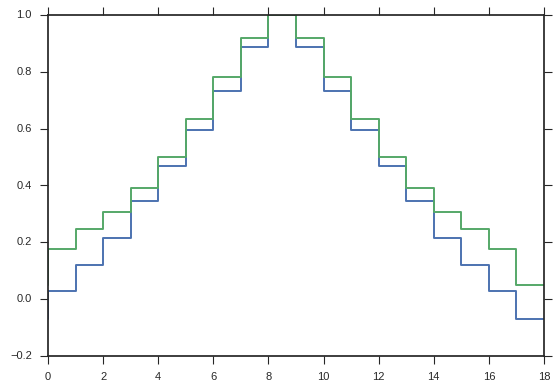

In [66]:
plt.step(np.arange(len(actual_ctx_similarities)), actual_ctx_similarities)
plt.step(np.arange(len(ideal_ctx_similarities)), ideal_ctx_similarities)

In [7]:
def update_context(t):
    if t < env.init_phase or (t > 1. and .3 < (t % 1.) < .7):
        return 1.
    else:
        return 0.

def X(env):
    with nengo.Network(seed=2) as model:
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = Context5(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        nengo.Connection(nengo.Node(update_context), context_net.input_update_context)

        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.diff.input)
        nengo.Connection(initialization_node, context_net.old.diff.input)
        #nengo.Connection(nengo.Node(lambda t: 4 if t < env.init_phase else 0.), context_net.old.store)
        #nengo.Connection(nengo.Node(lambda t: -1 if t < env.init_phase - 0.1 else 0.), context_net.buf.store)

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
    return model

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:235: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


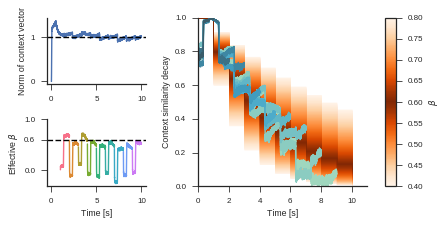

In [8]:
env = ContextTestEnv(1)
fig = eval_net(X(env), env)

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:235: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


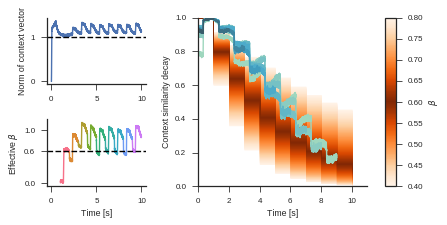

In [9]:
env = ContextTestEnv(1, beta_stim=0.6)
fig = eval_net(X(env), env)